# Model Selection and Hyperparameter Tuning

In this notebook we will select the best model with the best hyperparameters and use two methods used in model selection: holdout method and k-fold cross-validation.

## What is Model Selection?
Model selection: how to select the final model from potential candidate models based on their performance on the training dataset
- select a model from different types of models, e.g. from three classifiers: logistic regression, decision tree and KNN
- select a model from the same model with different model hyperparameters, e.g., from the decision tree model with different tree depths

Model evaluation: how to evaluate the performance of a candidate models using certain metrics, e.g., accuracy

## Considerations in Model Selection
In a business project, model selection is not only a technical problem
There are many considerations such as
- business requirements
- cost
- performance
- state-of-the-art
- maintenance
It is difficult or impossible to find the best model meeting all criteria. Usually, turn to find a satisfactory model

The best model in terms of technical performance may not be the best in business
- Netflix prize In 2009, 'Netflix held the Netflix Prize open competition for the best algorithm to predict user ratings for films. The grand prize was $1,000,000 and was won by BellKor's Pragmatic Chaos team. But this algorithm was never used by Netflix

## Parameter and Hyperparameter
A machine learning model always has a few parameters. Some deep learning models even have over hundred parameters

Parameters of a model can be classified into two types:

- **parameter**: internal coefficients or weights for a model

    - e.g., Logistic regression: coefficients $(\beta_0 ,..., \beta_n) $
    $$
    \pi(x) = \frac{e^{\beta_0 + \beta_1x_1 + \dots \beta_n x_n}}{1 + e^{\beta_0 + \beta_1x_1 + \dots \beta_n x_n}}
    $$
 
    - learned in model fitting
    - fitting is to find optimal internal model parameters
- **hyperparameter**: specified by practitioner when configuring the model
    - e.g. decision tree: depth of a tree
    - tuned by practitioner

Tuning hyper-parameters may significantly improve the performance of a machine learning model

## Overfitting and Underfitting
Overfitting
- A model performs very well on the training data but not on the test data

Underfitting
- A model fits the training data not well and does not the fit test data very well

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, validation_curve, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score


## Example: (Underfitting)

Accuracy Train:  0.7980456026058632
Accuracy Test:  0.7792207792207793


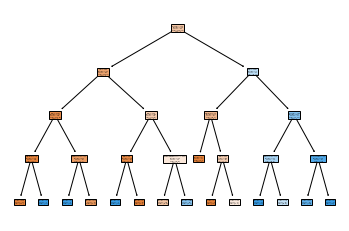

In [10]:
df = pd.read_csv('diabetes.csv')
X = df.iloc[:,0:8]
y = df.iloc[:,8]

train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=.2, random_state=4)

clf = DecisionTreeClassifier(criterion='entropy', max_depth=4)
clf = clf.fit(train_x, train_y)

pred_train = clf.predict(train_x)
pred_test = clf.predict(test_x)

print('Accuracy Train: ', accuracy_score(train_y, pred_train))
print('Accuracy Test: ', accuracy_score(test_y, pred_test))

fig = plt.figure()
_ = plot_tree(clf, feature_names=df.columns, class_names =['0','1'], filled=True)

## Example: (Overfitting)

Accuracy Train:  1.0
Accuracy Test:  0.7272727272727273


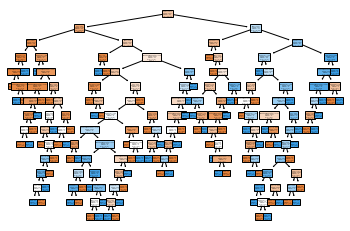

In [11]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth=15)
clf = clf.fit(train_x, train_y)

pred_train = clf.predict(train_x)
pred_test = clf.predict(test_x)

print('Accuracy Train: ', accuracy_score(train_y, pred_train))
print('Accuracy Test: ', accuracy_score(test_y, pred_test))

fig = plt.figure()
_ = plot_tree(clf, feature_names=df.columns, class_names =['0','1'], filled=True)

# Manually Tuning Hyperparameter: Holdout Method

## Holdout method: training, validation and test datasets
Separate the data into three parts
- Training dataset: used to find the best internal parameter of a model
- Validation dataset: used for model selection and hyperparameter tuning
- Test dataset: used to evaluate the performance of a model

## Example

In [14]:
#split data into training, val, test data 60/20/20
train_x, test_x, train_y, test_y = train_test_split(X,y,test_size=0.2,random_state=4)
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.25, random_state=4)

In [15]:
#set range of max_depth
max_depth_range = range(1, 16) 

#create two lists which record results
val_results = []
train_results = []

In [16]:
#calculate the accuracy of decision tree model with max_depth in [1,15] 
for k in max_depth_range:
    clf = DecisionTreeClassifier(max_depth=k)
    clf = clf.fit(train_x, train_y)

    #accuracy on training
    pred_train = clf.predict(train_x)
    train_score = accuracy_score(train_y, pred_train) 
    train_results.append(train_score)

    #accuracy on validation data
    pred_val = clf.predict(val_x) 
    val_score = accuracy_score(val_y, pred_val) 
    val_results.append(val_score)

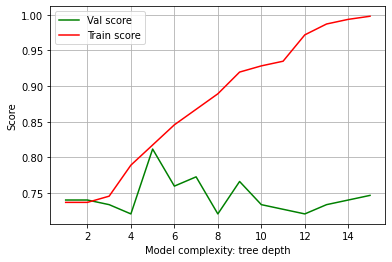

In [17]:
#plot the score curves on both validation and test datasets
plt.plot(max_depth_range, val_results, 'g-', label='Val score')
plt.plot(max_depth_range, train_results, 'r-', label='Train score')
plt.ylabel('Score')
plt.xlabel('Model complexity: tree depth')
plt.legend()
plt.grid(True)
plt.show()

Model Selection
- Since the tree with max_depth = 5 has the highest score on validation data, it will be selected as the final model
- For big data, validation data may cover many records similar to test data. Holdout method may work well
- For small data, validation data may not cover few records similar to test data. Holdout method may not work well

Model Evaluation
- Evaluate the best model on test data

In [35]:
clf_best = DecisionTreeClassifier(max_depth=5)
clf_best = clf_best.fit(train_x, train_y)
y_pred_train = clf_best.predict(train_x)
y_pred_test = clf_best.predict(test_x)
print("training accuracy",accuracy_score(train_y, y_pred_train))
print("testing accuracy",accuracy_score(test_y, y_pred_test))

training accuracy 0.8173913043478261
testing accuracy 0.7662337662337663


# Manually Tuning Hyperparameter: k-fold cross-validation

## k-fold cross-validation

In k-fold cross-validation, randomly split the training dataset into k folds without replacement
- k −1 folds are used for training
- 1 fold is used for validation

This procedure is repeated k times so that we obtain k models and performance estimates.

Advantage:
- Each sample point will be part of a training and test dataset exactly once

How Many Folds?

The more folders, the more computation time. Very large data sets: 3-fold cross validation is good choice. Very small data sets: use leave-one-out is good choice

Common choice
- Many researchers use k=10 as this seems to be good choice for many data

## Example

In [36]:
train_x,test_x,train_y,test_y = train_test_split(X,y,test_size=0.2,random_state=4) 
clf = DecisionTreeClassifier(criterion='entropy')

In [38]:
scores = cross_val_score(clf, train_x, train_y, cv=10,scoring="accuracy")
print("accuracy on validation data", scores)
print("mean", np.mean(scores))

accuracy on validation data [0.70967742 0.61290323 0.74193548 0.74193548 0.75409836 0.68852459
 0.68852459 0.73770492 0.7704918  0.67213115]
mean 0.7117927022739291


In [41]:
def plot_validation_curve(clf, X, y, param_name, param_range):
    train_scores, test_scores = validation_curve(clf, X, y,
                                                 cv=10, 
                                                 scoring="accuracy",  
                                                 param_name=param_name,
                                                 param_range=param_range,
                                                 n_jobs=-1)
    plt.figure(figsize=(6,4))
    x_range = param_range 
    train_scores_mean =  np.mean(train_scores, axis=1) 
    test_scores_mean = np.mean(test_scores, axis=1) 
    plt.plot(x_range, train_scores_mean, 'g-', label='Training score')
    plt.plot(x_range, test_scores_mean, 'b-', label='Validation score')
    plt.ylabel('Score')
    plt.xlabel('Model complexity: tree depth')
    plt.text(6, 0.8, 'Overfitting',fontsize=12,color="r")
    plt.text(1, 0.8, 'Underfitting',fontsize=12,color="r")
    plt.axvline(4, ls='--') 
    plt.legend()
    plt.grid(True)
    plt.show()

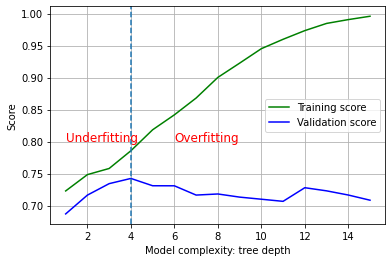

In [42]:
plot_validation_curve(clf, train_x, train_y, param_name='max_depth', param_range=range(1,16))

Model Evaluation
- Evaluate the model on test data

In [43]:
clf_best = DecisionTreeClassifier(max_depth=4)
clf_best = clf_best.fit(train_x, train_y)
y_pred_train = clf_best.predict(train_x)
y_pred_test = clf_best.predict(test_x)
print("training accuracy",accuracy_score(train_y, y_pred_train))
print("testing accuracy",accuracy_score(test_y, y_pred_test))

training accuracy 0.8078175895765473
testing accuracy 0.7792207792207793


Disadvantages in Manual Tuning
- Tune one hyperparameter at each time but a model may have many hyperparameters
- Find the optimal value manually through observing a plotting

# Automatic Tuning of Hyperparameters: k-fold cross-validation

## Automatic Tuning of hyperparameters: Search

Sklearn provides two methods to automaically tune hyperparamters

GridSearchCV exhaustively generates candidates from a grid of parameter values specified with the param_grid parameter
- apply a brute-force exhaustive search to different combinations of hyper-parameters
- evaluates the model performance for each combination

RandomizedSearchCV implements a randomized search over parameters
- apply randomized search to different combinations of hyper-parameters
- each setting is sampled from a distribution over possible combinations (but not exhaustively)

## Example GridSearchCV (brute-force exhaustive search)

- Classifier: decision tree
- Hyperparameters
    - criterion: this parameter is to measure the quality of a split. There are two options
        - gini for the Gini impurity
        - entropy for the information gain
- max_depth: set its range [1,15]
- Total  2×15=30 combinations

In [45]:
# create Decision Tree classifer object
clf = DecisionTreeClassifier() 
param_grid = [{'criterion':['gini'], 'max_depth':list(range(1,16))},
               {'criterion':['entropy'], 'max_depth':list(range(1,16))}]

# create a grid search object 
gs = GridSearchCV(clf, param_grid, scoring='accuracy', cv=10)                          
# fit model using grid search
gs = gs.fit(train_x,train_y)
 
#set the clf to the best combination of parameters
clf_best = gs.best_estimator_
print("best model:", clf_best.get_params())

# Fit the best model to the data. 
clf_best = clf_best.fit(train_x, train_y)

y_pred_train = clf_best.predict(train_x)
y_pred_test = clf_best.predict(test_x)
print("training accuracy",accuracy_score(train_y, y_pred_train))
print("testing accuracy",accuracy_score(test_y, y_pred_test))

best model: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 4, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}
training accuracy 0.7980456026058632
testing accuracy 0.7792207792207793


## Example RandomizedSearchCV (Randomized Search)

- Classifier: decision tree
- Hyperparameters
    - criterion: this parameter is to measure the quality of a split. There are two options
        - gini for the Gini impurity
        - entropy for the information gain
- max_depth: set its range [1,15]
- Total  2×15=30 combinations

In [46]:
# create Decision Tree classifer object
clf = DecisionTreeClassifier() 
param_grid = [{'criterion':['gini'], 'max_depth':list(range(1,16))},
               {'criterion':['entropy'], 'max_depth':list(range(1,16))}]

# create a grid search object 
rs = RandomizedSearchCV(clf, param_grid, scoring='accuracy', cv=10)                          
# fit model using grid search
rs = rs.fit(train_x,train_y)
 
#set the clf to the best combination of parameters
clf_best = rs.best_estimator_
print("best model:", clf_best.get_params())

# Fit the best model to the data. 
clf_best = clf_best.fit(train_x, train_y)

y_pred_train = clf_best.predict(train_x)
y_pred_test = clf_best.predict(test_x)
print("training accuracy",accuracy_score(train_y, y_pred_train))
print("testing accuracy",accuracy_score(test_y, y_pred_test))

best model: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 4, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}
training accuracy 0.8078175895765473
testing accuracy 0.7857142857142857


# Summary
- Model selection is to select the final model from potential candidate models based on their performance on the training dataset
- Overfitting means that a model fits training data very well but does not fit test data very well. Overfitting often happens in a complex model
- Tuning hyper-parameters may significantly improve the performance of a machine learning model and avoid overfitting
- Manual tuning of hyperparameters can be implemented through the holdout method or k-fold cross-evaluation
- Automatic Tuning of hyperparameters can be implemented through grid search